Team *Spatial Extent*

**Custom Model final version**

This is our custom model in its final version, more details can be found in the report

# Data Loading

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json #read json labels file
from PIL import Image #images operations
import os
from datetime import datetime
from sklearn.utils import shuffle 
import math

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator   

In [ ]:
#For colab with dataset on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Unzip dataset from Drive
!unzip '/content/drive/My Drive/_Polimi/artificial-neural-networks-and-deep-learning-2020.zip'

Archive:  /content/drive/My Drive/_Polimi/artificial-neural-networks-and-deep-learning-2020.zip
replace MaskDataset/test/10001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: MaskDataset/test/10001.jpg  
replace MaskDataset/test/10040.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
dataset_dir = os.path.join(os.getcwd(), 'MaskDataset')
training_dir = os.path.join(dataset_dir,'training')
test_dir = os.path.join(dataset_dir,'test')

In [ ]:
SEED=1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
apply_data_augmentation = True
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=30,
                                       width_shift_range=30,
                                       height_shift_range=30,
                                       zoom_range=0.4,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='constant', #the new pixel introduced, for instance rotating the image, will be filled with the constant value cval
                                       cval=0,
                                        rescale=1/255. ,
                                        validation_split=0.1
                                       )
else:
    train_data_gen = ImageDataGenerator(rescale=1/255., validation_split=0.1)

valid_data_gen = ImageDataGenerator(rescale=1/255., validation_split=0.1)

In [ ]:
bs=8

img_w = 612
img_h = 408

with open(os.path.join(dataset_dir,"train_gt.json")) as f:
    dic = json.load(f)
dataframe = pd.DataFrame(dic.items())
dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)
dataframe["class"] = dataframe["class"].astype(str)
#Necessary to shuffle, othwerwise the dataframe is automatically 
#ordered by class and then the splitting takes all class of the same type in the validation set
dataframe = shuffle(dataframe)
print(dataframe)

train_gen = train_data_gen.flow_from_dataframe(dataframe,
                                           training_dir,
                                           batch_size=bs,
                                           target_size=(img_h, img_w), 
                                           class_mode='categorical',
                                           shuffle=True,
                                           seed=SEED,subset="training")


valid_gen = valid_data_gen.flow_from_dataframe(dataframe,
                                           training_dir,
                                           batch_size=bs,
                                           target_size=(img_h, img_w),
                                           class_mode='categorical',
                                           shuffle=True,
                                           seed=SEED,subset="validation")

       filename class
857   16798.jpg     0
3018  12573.jpg     1
2715  12407.jpg     1
5117  17152.jpg     2
5463  13853.jpg     2
...         ...   ...
664   12240.jpg     0
3276  12184.jpg     1
1318  11589.jpg     0
723   10851.jpg     0
2863  15683.jpg     1

[5614 rows x 2 columns]
Found 5053 validated image filenames belonging to 3 classes.
Found 561 validated image filenames belonging to 3 classes.


In [ ]:
num_classes = 3

train_dataset = tf.data.Dataset.from_generator(lambda:train_gen,output_types=(tf.float32,tf.float32),
                                              output_shapes=([None, None, None, 3],[None,num_classes])
                                              )

valid_dataset = tf.data.Dataset.from_generator(lambda:valid_gen,output_types=(tf.float32,tf.float32),
                                              output_shapes=([None, None, None, 3],[None,num_classes])
                                              )

train_dataset = train_dataset.repeat()
valid_dataset = valid_dataset.repeat()



Just to check that we are loading properly the images

In [ ]:
iterator = iter(train_dataset)

<tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

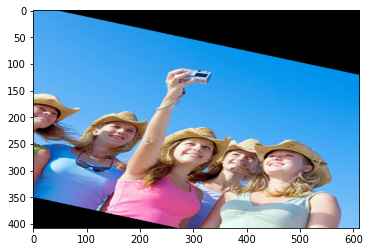

In [ ]:
sample,target = next(iterator)

sample = sample[0,...]
sample = tf.math.scalar_mul(255,sample) #denormalize the image

img = Image.fromarray(np.uint8(np.array(sample)))
import matplotlib.pyplot as plt
plt.imshow(img)

img.size
target

# Model definition and training

In [ ]:
filter_num = 16
start_f = filter_num

depth = 8


model = tf.keras.Sequential()
for i in range(depth):
    if i==0:
        input_shape = [img_h,img_w, 3]   
    else:
        input_shape = [None]
    model.add(tf.keras.layers.Conv2D(filters=start_f,
                                    kernel_size=(3,3),
                                    strides = (1,1),
                                    padding='same',
                                    input_shape = input_shape ,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.001)
                                    ))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    start_f *= 2
    
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 408, 612, 16)      448       
_________________________________________________________________
re_lu (ReLU)                 (None, 408, 612, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 204, 306, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 204, 306, 32)      4640      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 204, 306, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 102, 153, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 102, 153, 64)      1

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()

lr = 1e-5
epochs_num = 40
Adam = True
if Adam == True:
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
else:
  decay_rate = lr / epochs
  momentum = 0.8
  optimizer = tf.keras.optimizers.SGD(lr=lr, decay=decay_rate, nesterov=False)

metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
drivedir = '/content/drive/My Drive/_Polimi/NN'
print(drivedir)

expname = 'Model_bs' + str(bs) + '_filt' + str(filter_num) + '_depth' + str(depth) + '_learnRat' + str(lr)
exps_dir = os.path.join(drivedir,expname)
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)
now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_dir = os.path.join(exps_dir,str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
callbacks = []

#Model checkpoint
ckpt_dir = os.path.join(exp_dir,'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir,'cp_{epoch:02d}.ckpt'),
                                                   save_weights_only=True, 
                                                   verbose=1, 
                                                   monitor='val_accuracy',
                                                   mode='max',
                                                   save_best_only=True)
callbacks.append(ckpt_callback)

#Tensorboard
tb_dir = os.path.join(exp_dir,'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,histogram_freq=1)
callbacks.append(tb_callback)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, min_delta=0.01, restore_best_weights=True)
callbacks.append(es_callback)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.1,patience=5,min_delta=0.01)
#callbacks.append(reduce_lr_callback)

/content/drive/My Drive/_Polimi/NN


In [ ]:
from contextlib import redirect_stdout
summarydir = exp_dir + '/modelsummary.txt'
with open(summarydir, 'w') as f:
    with redirect_stdout(f):
        model.summary()
        expname

The best weights can be found here https://drive.google.com/drive/folders/1-3HMeZ-7IXXmKpyQEnwJUPYA7_n51xLe?usp=sharing

In [ ]:
ckpt_dir = '/content/drive/My Drive/_Polimi/NN/Modello da 0.8666/ckpts/cp_01.ckpt'
model.load_weights(ckpt_dir)

In [ ]:
model.fit(x=train_dataset,
         epochs=50,
         steps_per_epoch=len(train_gen),
         validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=callbacks
          )

# Test

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
from PIL import Image
import numpy as np


image_filenames = next(os.walk('MaskDataset/test'))[2]


results = {}
for image_name in image_filenames:
    img = Image.open('/content/MaskDataset/test/' + image_name).convert('RGB')
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, 0)
    softmax = model.predict(img_array)
    prediction = np.argmax(softmax) 
    print(prediction)
    results[image_name] = prediction

create_csv(results)